## Proyecto del Día 13 - Juego de Navegación en un Laberinto

Este proyecto tiene como objetivo desarrollar un entorno de laberinto simple y aplicar un algoritmo de **Aprendizaje por Refuerzo** para enseñar a una IA a navegar desde un punto inicial hasta un objetivo.

Dada la naturaleza de este proyecto, considero que el algoritmo más adecuado para este tipo de probleas es **Q-Learning**, por su facilidad de implelentación y comprensión, su estabilidad y su relación entre la exploración y la explotación.

Por esa razón te propongo resolverlo usando ese algoritmo, aunque dejo a tu criterio si quieres resolverlo con otro algoritmo de tu elección. Siempre estaré a favor de que investigues, y expandas las habilidades propuestas por tu cuenta.

### Descripción del Laberinto:

El laberinto se representa como una matriz de dos dimensions, donde cada elemento puede ser:
+ un camino libre (0)
+ un obstáculo (1)
+ el objetivo (G)

La tarea es desarrollar un agente que pueda aprender a encontrar el camino desde un punto de inicio hasta el objetivo evitando obstáculos.


### Creación del Laberinto

Debido a que el desafío de hoy es bastante complejo, y que el objetivo final no se trata de que sepas desarrollar laberintos, sino sistemas para resolverlos, voy a facilitar la tarea entregando en este cuaderno el código para generar nuestros laberintos.

Tu parte será la siguiente, que es diseñar y entrenar un modelo de Q-Learning para resolver el laberinto de la manera mpas eficiente, y luego mostrar una visualización sobre cómo lo ha hecho.

Te deseo toda la suerte del mundo, y sobre todo, que te diviertas de a montones.

In [442]:
# Librerías necesarias para todo el ejercicio
import numpy as np
import matplotlib.pyplot as plt
import random

In [443]:
# Función para crear el laberinto
def crear_laberinto(tamanio, porcentaje_paredes=20, inicio=(0, 0), meta=None):
    laberinto = np.zeros((tamanio, tamanio))
    numero_paredes = int((tamanio * tamanio) * porcentaje_paredes / 100)
    
    # Ubicar paredes
    for pared in range(numero_paredes):
        x, y = random.randint(0, tamanio-1), random.randint(0, tamanio-1)
        
        # Cuidar que inicio y meta no sean paredes
        if (x, y) != inicio and (meta is None or (x, y) != meta):
            laberinto[x, y] = 1
            
    # Ubicar la meta
    if meta:
        laberinto[meta] = 9  # Representa la meta con 9
    else:
        # Ubicar la meta aleatoriamente si no está especificado
        while True:
            x, y = random.randint(0, tamanio-1), random.randint(0, tamanio-1)
            if laberinto[x, y] == 0 and (x, y) != inicio:
                laberinto[x, y] = 9
                break
    
    return laberinto

In [444]:
# Función para visualizar el laberinto
def ver_laberinto(laberinto):
    plt.figure(figsize=(5, 5))
    plt.imshow(laberinto, cmap='hot', interpolation='nearest')
    plt.colorbar();

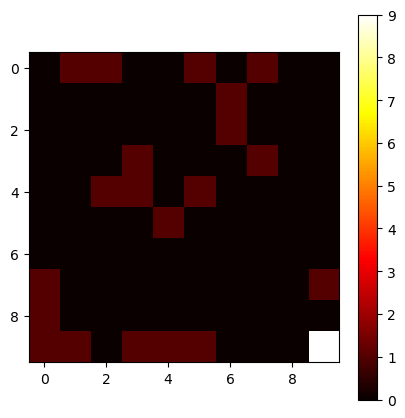

In [448]:
# Ejemplo de crear y mostrar laberintos
laberinto = crear_laberinto(10, 20, inicio=(0, 0), meta=(9, 9))
ver_laberinto(laberinto)

### Ahora te toca a ti

Lo que sigue es implementar todo el código para que un algoritmo de Q-Learning encuentre la manera más eficiente de llegar a la meta. Voy a dejarte los pasos que considero que son los necesarios para lograrlo

##### 1. Parámetros para el algoritmo Q-Learning

In [483]:
learning_times =500 # Times that leaning is repeated

class MazeSolver:
    
    def __init__( self, maze=None, alpha=0.1, gamma=0.99, epsilon=0.2, initial_state=(0,0), obj_state=(0,0) ):        
        # Dimensions (Based on the Maze data)
        self.maze = maze
        self.dimensions = maze.shape
        
        # States
        self.initial_state = initial_state #index (i,j) in the laberinth
        self.obj_state = obj_state #index (i,j) in the laberinth
        self.state_num = self.dimensions[0]*self.dimensions[1] # for a 5,5 laberinth its 5x5 = 25
        self.state = initial_state #current state (i,j) in the laberinth
        self.s = 0 #index of the state (e.g. in a 5x5 laberinth (5,5) == 24)
        self.next_state = (0,0) #next state (i,j) in the laberinth
        self.next_s = 0 #index of the next state

        # Learning conditions
        self.alpha = alpha #learning ratio
        self.gamma = gamma # discount factor
        self.epsilon = epsilon #explore-exploit factor

        # Actions
        self.actions = ((-1,0),(1,0),(0,-1),(0,1))
        self.actions_num = len(self.actions)
        self.a = None #one of the four possible choises in a 2D laberinth
        self.actions_sym = ['↑', '↓', '←', '→']

        # Create Matrix Q(s,a)
        self.Q = np.zeros((self.state_num,self.actions_num)) # Q(s,a)

        # Ending condition
        self.terminate = False
        self.reward = 0
    
    
    # State to index. This is s in the Matrix Q
    def state_to_index(self,state):
        self.s = self.state[0]*self.dimensions[1] + self.state[1]
        return self.s

    # Index to state. This is the state in the laberinth
    def index_to_state(self,s):
        i = s // self.dimensions[0]
        j = s % self.dimensions[1]
        self.state = [i,j]

    def choose_action(self):               
        #if explore - >
        if np.random.rand(1)  < self.epsilon:
            self.a = random.randint(0, self.actions_num - 1)
        #Exploit (use the best action known in Q)
        else:
            self.a = np.argmax(Q[self.s,:])

    def is_obstacle(self,state):
        if self.maze[state] == 1:
            return True
    
    def apply_action(self):
        # Set new positions considering limits
        # 1. up limit
        if self.state[0] == 0 and self.a == 0:
            next_state = self.state
        # 2. down limit
        elif self.state[0] == self.dimensions[0]-1 and self.a == 1:
            next_state = self.state
        # 3. left limit
        elif self.state[1] == 0 and self.a == 2:
            next_state = self.state
        # 4. right limit
        elif self.state[1] == self.dimensions[1]-1 and self.a == 3:
            next_state = self.state
        else:
            next_state= tuple(np.add(self.state,self.actions[self.a]))

        # set rewards or ending condition
        terminate = False
        if next_state == self.state and next_state != self.obj_state:
            reward = -100
        if next_state != self.state and not(self.is_obstacle(next_state)):
            reward = -1
        if self.is_obstacle(next_state): ## if is obstacle == True
            reward = -100
        if next_state == self.obj_state:
            reward = 100
            terminate = True

        self.reward = reward
        self.terminate = terminate
        self.next_state = next_state
        self.next_s = self.state_to_index(next_state)        

    def update_Q_matrix(self):
        self.Q[self.s,self.a] = self.Q[self.s,self.a] + self.alpha * (self.reward + self.gamma * np.max(self.Q[self.next_s]) - Q[self.s,self.a])

    def update_state(self):
        self.state = self.next_state
        self.s = self.next_s

    def restart(self):
        # States
        self.initial_state = (0,0) #index (i,j) in the laberinth
        self.state = (0,0) #current state (i,j) in the laberinth
        self.s = 0 #index of the state (e.g. in a 5x5 laberinth (5,5) == 24)
        self.next_state = (0,0) #next state (i,j) in the laberinth
        self.next_s = 0

        # Actions
        self.a = None #one of the four possible choises in a 2D laberinth
        
        # Ending condition
        self.terminate = False
        self.reward = 0
        

In [484]:
solver = MazeSolver(maze=laberinto)

##### 2. Función para elegir acciones equilibrando entre explotación y exploración

In [485]:
for episode in range(learning_times):
    solver.restart()
    
    while not(solver.terminate):
        solver.choose_action()
        solver.apply_action()
        solver.update_Q_matrix()
        solver.update_state()

##### 3. Función para simular la acción en el laberinto

In [486]:
print(np.round(solver.Q,2))

[[ 7.67417193e+08  3.31054107e+09  1.02286853e+09  2.76361590e+10]
 [ 5.31676360e+75  4.86685843e+75  8.11652475e+74  2.33364658e+75]
 [-3.48473316e+27 -2.49484500e+26 -1.54842147e+26 -2.09373593e+26]
 [-1.65675749e+25 -6.00605260e+23 -1.10024928e+24 -9.67759618e+23]
 [-2.41314954e+24 -1.71051860e+23 -1.78824263e+23 -2.13526815e+23]
 [-1.92257553e+24 -1.52896902e+23 -1.44492789e+23 -1.66907065e+23]
 [-2.80726638e+25 -1.96910976e+24 -1.60363511e+24 -1.48541564e+24]
 [-1.50226905e+23 -8.58489119e+21 -6.43964536e+21 -8.38407167e+21]
 [-1.40595321e+23 -8.64358650e+21 -6.83843833e+21 -7.69262805e+21]
 [-1.52904269e+23 -6.18307900e+21 -1.21212236e+22 -7.69347582e+21]
 [ 4.78431997e+11  2.52877565e+10  2.67397288e+10  1.49190326e+11]
 [-4.81995135e+06 -5.17842326e+06 -6.13110200e+05 -8.10099510e+05]
 [-2.27020500e+04 -5.15010000e+02 -6.54990000e+02 -6.35590000e+02]
 [-5.58980000e+02 -3.48600000e+01 -3.69700000e+01 -3.31600000e+01]
 [-5.33780000e+02 -5.36800000e+01 -5.59400000e+01 -3.72100000e

##### 4. Función principal para ejecutar el algoritmo Q-Learning

##### 5. Función para convertir coordenadas a índice lineal

##### 6. Iniciar el laberinto y configurar el algoritmo Q-Learning

##### 7. Función para mostrar el aprendizaje del agente

##### 8. Visualizar el resultado